In [48]:
!pip install pandas matplotlib seaborn scikit-learn scipy


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [50]:
# --- Load ---
df = pd.read_csv("gym_data.csv")
df["date"] = pd.to_datetime(df["date"])


In [51]:
# Drop workout_type (as decided)
if "workout_type" in df.columns:
    df = df.drop(columns=["workout_type"])

In [52]:
# Basic checks
print(df.info())
print(df.isnull().sum())
df = df.dropna()

# Sort by date
df = df.sort_values("date").reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 60 non-null     datetime64[ns]
 1   workout_day          60 non-null     int64         
 2   workout_duration     60 non-null     int64         
 3   perceived_intensity  60 non-null     int64         
 4   sleep_duration       60 non-null     float64       
 5   screen_time          60 non-null     float64       
 6   productivity_score   60 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 3.4 KB
None
date                   0
workout_day            0
workout_duration       0
perceived_intensity    0
sleep_duration         0
screen_time            0
productivity_score     0
dtype: int64


In [73]:
# --- Descriptive stats ---
df.describe()

,date,workout_day,workout_duration,perceived_intensity,sleep_duration,screen_time,productivity_score,rolling_productivity
count,60,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,54.000000
mean,2025-12-30 12:00:00,0.733333,72.266667,5.900000,6.750000,9.858333,3.450000,3.452381
min,2025-12-01 00:00:00,0.000000,0.000000,0.000000,6.000000,0.400000,3.000000,3.285714
25%,2025-12-15 18:00:00,0.000000,0.000000,0.000000,6.200000,9.150000,3.000000,3.428571
50%,2025-12-30 12:00:00,1.000000,88.000000,7.000000,6.600000,9.800000,3.000000,3.428571
75%,2026-01-14 06:00:00,1.000000,116.250000,9.000000,7.500000,10.725000,4.000000,3.571429
max,2026-01-29 00:00:00,1.000000,140.000000,9.000000,7.900000,12.900000,4.000000,3.714286
std,NaN,0.445948,50.437700,3.667078,0.625042,1.701076,0.501692,0.135242


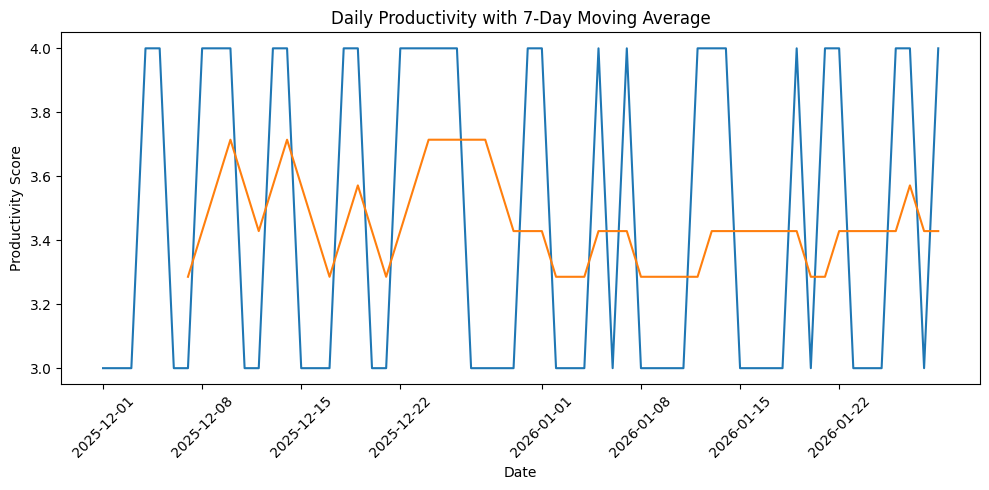

In [54]:
# =========================================================
# FIGURE 1: Productivity trend (with 7-day moving average)
# =========================================================
df["rolling_productivity"] = df["productivity_score"].rolling(window=7).mean()

plt.figure(figsize=(10,5))
plt.plot(df["date"], df["productivity_score"], label="Daily")
plt.plot(df["date"], df["rolling_productivity"], label="7-day MA")
plt.xlabel("Date")
plt.ylabel("Productivity Score")
plt.title("Daily Productivity with 7-Day Moving Average")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

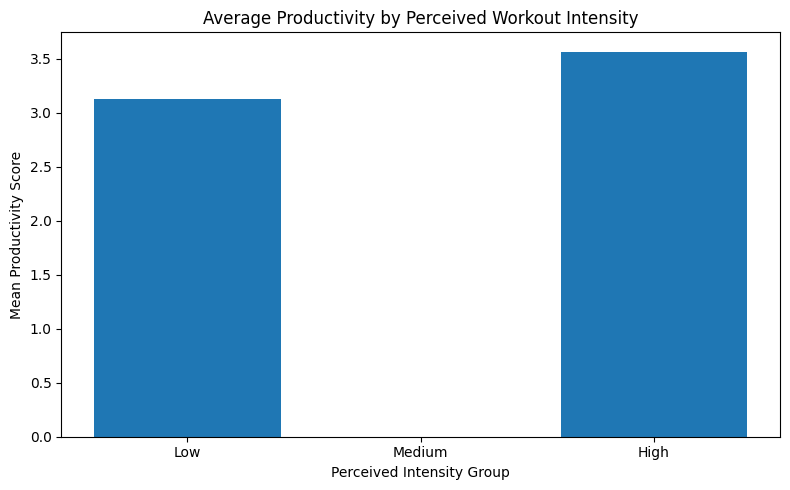

In [55]:
# =========================================================
# FIGURE 2: Mean productivity by intensity group (bar)
# =========================================================
bins_int = [-0.1, 3, 6, 9, 10]
labels_int = ["Low", "Medium", "High", "Very High"]
df["intensity_group"] = pd.cut(df["perceived_intensity"], bins=bins_int, labels=labels_int, include_lowest=True)

mean_int_prod = df.groupby("intensity_group", observed=False)["productivity_score"].mean()

plt.figure(figsize=(8,5))
plt.bar(mean_int_prod.index.astype(str), mean_int_prod.values)
plt.ylabel("Mean Productivity Score")
plt.xlabel("Perceived Intensity Group")
plt.title("Average Productivity by Perceived Workout Intensity")
plt.tight_layout()
plt.show()

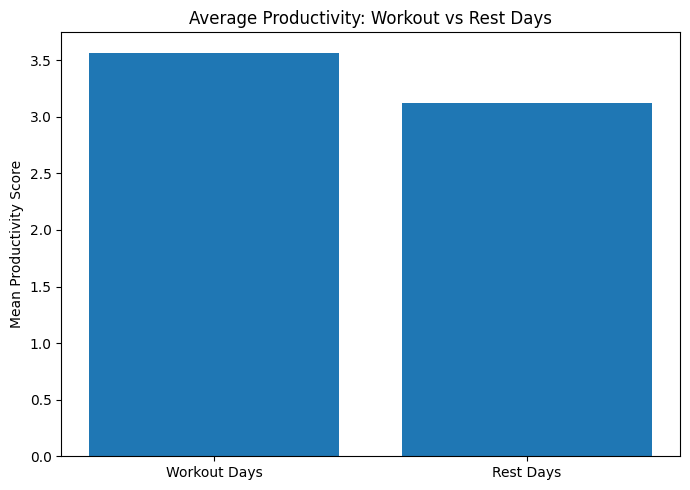

In [56]:
# =========================================================
# FIGURE 3: Mean productivity: Workout vs Rest (bar)
# =========================================================
mean_workout = df[df["workout_day"]==1]["productivity_score"].mean()
mean_rest = df[df["workout_day"]==0]["productivity_score"].mean()

plt.figure(figsize=(7,5))
plt.bar(["Workout Days","Rest Days"], [mean_workout, mean_rest])
plt.ylabel("Mean Productivity Score")
plt.title("Average Productivity: Workout vs Rest Days")
plt.tight_layout()
plt.show()

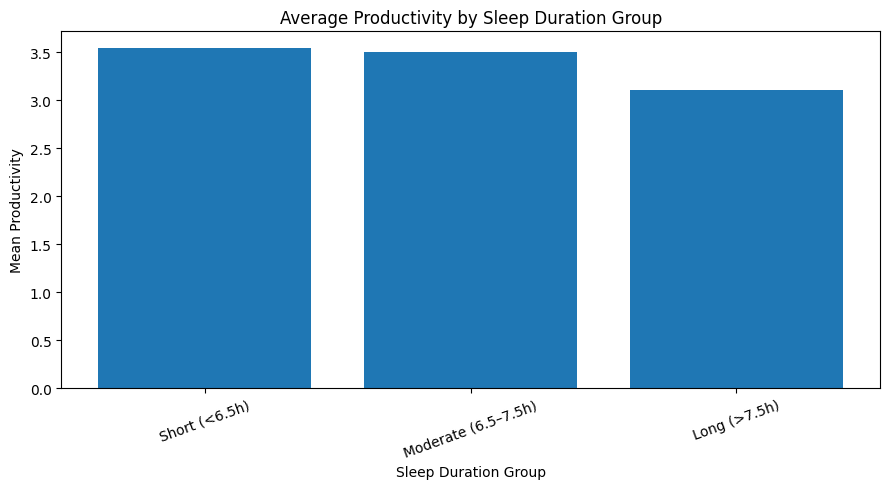

In [57]:
# =========================================================
# FIGURE 4: Mean productivity by sleep group (bar)
# =========================================================
bins_sleep = [0, 6.5, 7.5, 24]
labels_sleep = ["Short (<6.5h)", "Moderate (6.5–7.5h)", "Long (>7.5h)"]
df["sleep_group"] = pd.cut(df["sleep_duration"], bins=bins_sleep, labels=labels_sleep, include_lowest=True)

mean_sleep_prod = df.groupby("sleep_group", observed=False)["productivity_score"].mean()

plt.figure(figsize=(9,5))
plt.bar(mean_sleep_prod.index.astype(str), mean_sleep_prod.values)
plt.xlabel("Sleep Duration Group")
plt.ylabel("Mean Productivity")
plt.title("Average Productivity by Sleep Duration Group")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

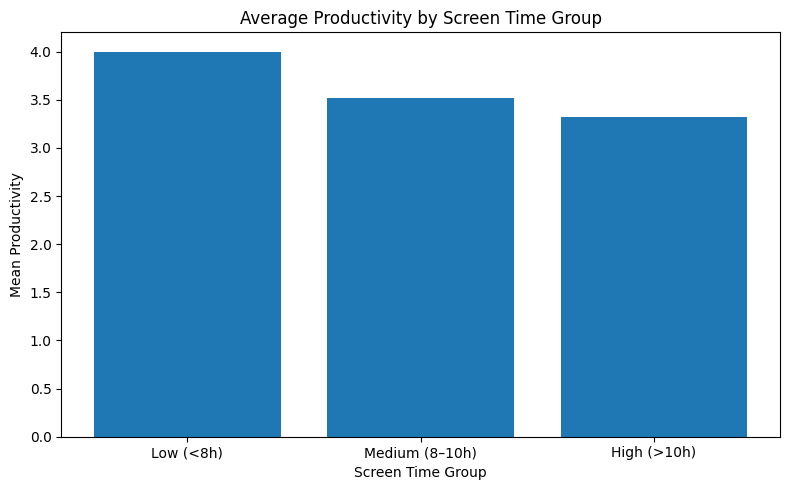

In [58]:
# =========================================================
# FIGURE 5: Mean productivity by screen time group (bar)
# =========================================================
bins_screen = [0, 8, 10, 24]
labels_screen = ["Low (<8h)", "Medium (8–10h)", "High (>10h)"]
df["screen_group"] = pd.cut(df["screen_time"], bins=bins_screen, labels=labels_screen, include_lowest=True)

mean_screen_prod = df.groupby("screen_group", observed=False)["productivity_score"].mean()

plt.figure(figsize=(8,5))
plt.bar(mean_screen_prod.index.astype(str), mean_screen_prod.values)
plt.xlabel("Screen Time Group")
plt.ylabel("Mean Productivity")
plt.title("Average Productivity by Screen Time Group")
plt.tight_layout()
plt.show()

In [59]:
# =========================================================
# Correlations
# =========================================================
def corr_report(xcol, ycol, label):
    r, p = pearsonr(df[xcol], df[ycol])
    print(f"{label}: r={r:.3f}, p={p:.4f}")
    return r, p

corr_report("sleep_duration", "productivity_score", "Sleep vs Productivity")
corr_report("perceived_intensity", "productivity_score", "Intensity vs Productivity")
corr_report("screen_time", "productivity_score", "Screen Time vs Productivity")

Sleep vs Productivity: r=-0.305, p=0.0177
Intensity vs Productivity: r=0.393, p=0.0019
Screen Time vs Productivity: r=-0.307, p=0.0169


(np.float64(-0.30733909651748464), np.float64(0.016908699852192358))

In [60]:
# =========================================================
# T-test: Workout vs Rest
# =========================================================
workout = df[df["workout_day"]==1]["productivity_score"]
rest = df[df["workout_day"]==0]["productivity_score"]
tt = ttest_ind(workout, rest, equal_var=False)  # safer default
print("T-test workout vs rest:", tt)

T-test workout vs rest: TtestResult(statistic=np.float64(3.8873340635841958), pvalue=np.float64(0.0003801052536788373), df=np.float64(39.271820436662416))


In [61]:
# =========================================================
# Regression (include workout_day as you wanted)
# =========================================================
X = df[["workout_day", "perceived_intensity", "sleep_duration", "screen_time"]]
y = df["productivity_score"]

model = LinearRegression()
model.fit(X, y)

pred = model.predict(X)

print("Intercept:", model.intercept_)
print("Coefficients (workout_day, intensity, sleep, screen):", model.coef_)
print("R^2:", r2_score(y, pred))

Intercept: 1.531334560669451
Coefficients (workout_day, intensity, sleep, screen): [ 0.25507905  0.06065398  0.30298511 -0.06810487]
R^2: 0.2194204052551434


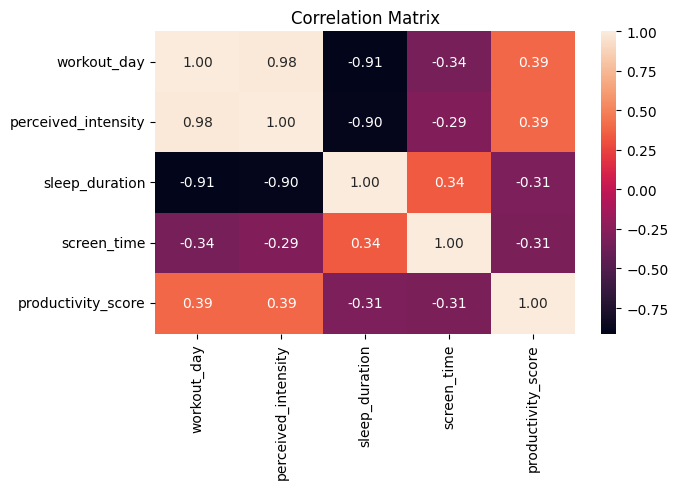

In [62]:
# =========================================================
# Correlation heatmap (keep seaborn for readability)
# =========================================================
plt.figure(figsize=(7,5))
sns.heatmap(df[["workout_day","perceived_intensity","sleep_duration","screen_time","productivity_score"]].corr(),
            annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()
